In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

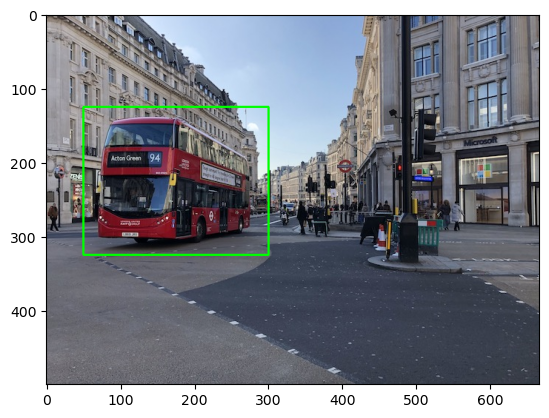

In [14]:

img = cv2.imread('OxfordCircus.jpeg')
bounding_box = (50,125,300,325)
cv2.rectangle(img, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0,255,0), 2)
plt.imshow(img[...,::-1])

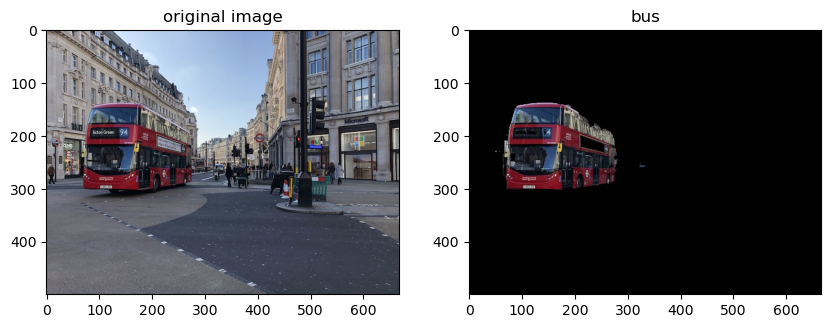

In [19]:
#image and bounding box
img = cv2.imread('OxfordCircus.jpeg')
bounding_box = (50,125,300,325)

#we should pass this mask to algorithm (grabcut will update it)
mask = np.zeros(img.shape[:2],np.uint8)
#constants ...
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
#calling grabcut
#GC_INIT_WITH_RECT -> how should i segment your picture (with our rectangle)
cv2.grabCut(img,mask,bounding_box,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
#mask 2 -> probable background
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#multiple mask2 * img -> remove backgrounds
result = img*mask2[:,:,np.newaxis]

plt.figure(figsize=[10,5])
plt.subplot(121);plt.imshow(img[...,::-1]);plt.title("original image");
plt.subplot(122);plt.imshow(result[...,::-1]);plt.title("bus");

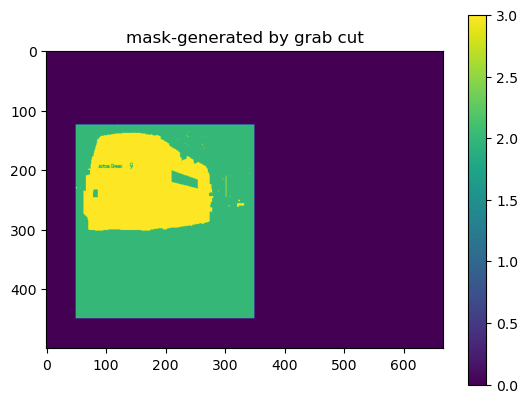

In [20]:
plt.imshow(mask),plt.colorbar(),plt.title("mask-generated by grab cut");plt.show();

## Refinement and Training

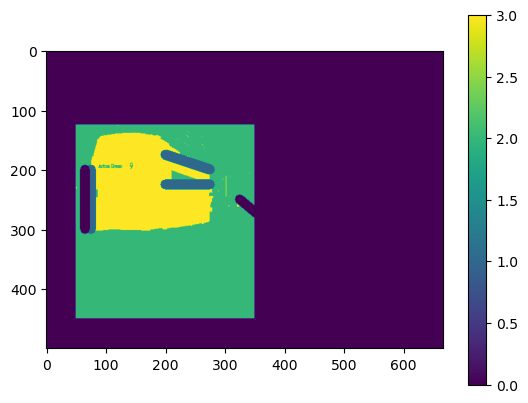

In [23]:
cv2.line(mask, (200,225), (275,225), cv2.GC_FGD, 15)
cv2.line(mask, (200,175), (275,200), cv2.GC_FGD, 15)
cv2.line(mask, (325,250), (355,275), cv2.GC_BGD, 15)
cv2.line(mask, (75,200), (75,300), cv2.GC_FGD, 15)
cv2.line(mask, (65,200), (65,300), cv2.GC_BGD, 15)
plt.imshow(mask),plt.colorbar(),plt.show();

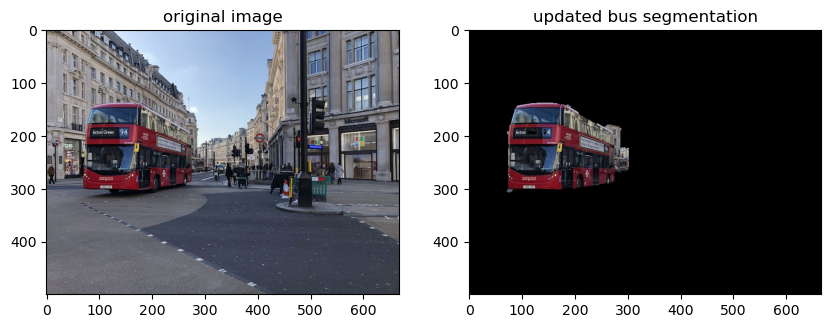

In [24]:
img = cv2.imread('OxfordCircus.jpeg')
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)
#WE WILL PASS TH UPDATED MASK HERE, NO MORE NEED FOR BOUNDING BOX
cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

mask2 = np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')
result = img*mask2[:,:,np.newaxis]

plt.figure(figsize=[10,5])
plt.subplot(121);plt.imshow(img[...,::-1]);plt.title("original image");
plt.subplot(122);plt.imshow(result[...,::-1]);plt.title("updated bus segmentation");

## GrabCut In use

first draw rectangle 



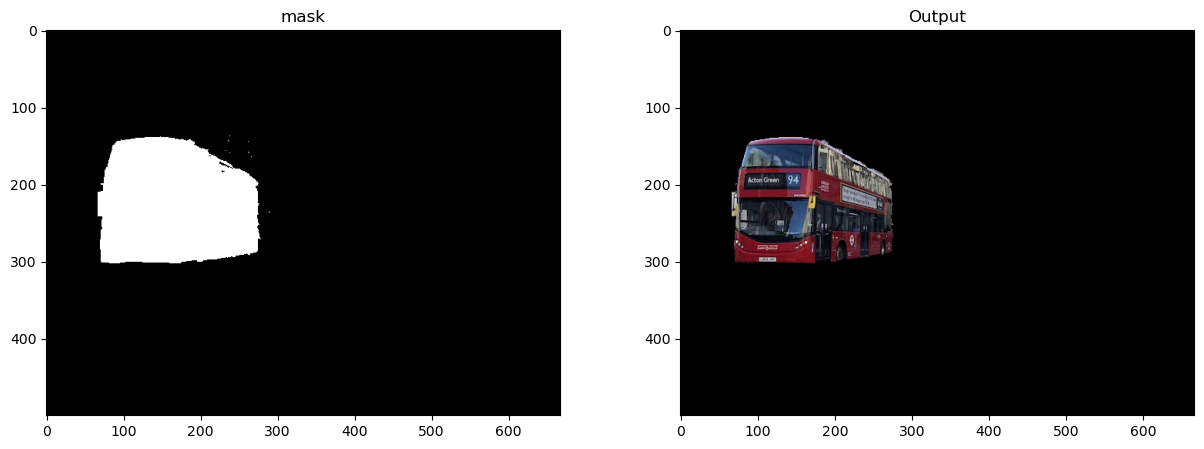

In [25]:
draw_rectangle = False
drawing = False
rect_or_mask = -1
rect_is_drew = False

def onmouse(event, x, y, flags, param):
     
    global draw_rectangle, start_point, rect, drawing, rect_or_mask, draw_image, rect_is_drew

    #check the first click of drawing the bounding box
    if event == cv2.EVENT_RBUTTONDOWN:
        draw_rectangle = True
        start_point = (x, y)

    #lets draw the bounding box over image after user's click
    elif event == cv2.EVENT_MOUSEMOVE:
        if draw_rectangle:
            draw_image = img.copy()
            cv2.rectangle(draw_image, start_point, (x, y), (255,0,0), 2)

    elif event == cv2.EVENT_RBUTTONUP:
        draw_rectangle = False
        cv2.rectangle(draw_image, start_point, (x, y), (255,0,0), 2)
        rect = (min(start_point[0], x), min(start_point[1], y), abs(start_point[0] - x), abs(start_point[1] - y))
        rect_is_drew = True
        rect_or_mask = 0

    # draw touchup curves
    if event == cv2.EVENT_LBUTTONDOWN:
        if not rect_is_drew:
            print("first draw rectangle \n")
        else:
            drawing = True
            cv2.circle(draw_image, (x,y), 3, value['color'], -1)
            cv2.circle(mask, (x,y), 3, value['val'], -1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(draw_image, (x, y), 3, value['color'], -1)
            cv2.circle(mask, (x, y), 3, value['val'], -1)

    elif event == cv2.EVENT_LBUTTONUP:
        if drawing == True:
            drawing = False

img = cv2.imread('OxfordCircus.jpeg')
draw_image = img.copy()                               # a copy of original image
mask = np.zeros(img.shape[:2], dtype = np.uint8)      # mask initialized to PR_BG
output = np.zeros(img.shape, np.uint8)                # output image to be shown

# input and output windows
cv2.namedWindow('output')
cv2.namedWindow('input')
cv2.setMouseCallback('input', onmouse)

#possible and absolute foreground and background images for updating the boxes and mask
DRAW_BG = {'color' : (0,0,0), 'val' : 0}
DRAW_FG = {'color' : (255,255,255), 'val' : 1}

while True:

    cv2.imshow('output', output)
    cv2.imshow('input', draw_image)
    k = cv2.waitKey(1)
    # key bindings -> updating results
    if k == 27:         # esc to exit
        break
    elif k == ord('0'): # BG drawing -> remove it grabcut! its back ground.
        value = DRAW_BG
    elif k == ord('1'): # FG drawing -> hey grab cut its our foreground!
        value = DRAW_FG
    elif k == ord('n'): # segment the image
        bgdmodel = np.zeros((1, 65), np.float64)
        fgdmodel = np.zeros((1, 65), np.float64)
        if rect_or_mask == 0:         # grabcut with rect
            cv2.grabCut(img, mask, rect, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_RECT)
            rect_or_mask = 1
        elif rect_or_mask == 1:       # grabcut with mask
            cv2.grabCut(img, mask, rect, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)


    mask2 = np.where((mask==1) + (mask==3), 255, 0).astype('uint8')
    output = cv2.bitwise_and(img, img, mask=mask2)

cv2.destroyAllWindows()
cv2.imwrite('grabcut_output_bus.png', output)

plt.figure(figsize=[15,5])
plt.subplot(121);plt.imshow(mask2, cmap='gray');plt.title("mask");
plt.subplot(122);plt.imshow(output[...,::-1]);plt.title("Output");